# TF를 통한 꽃 사진 전처리
- 기본적인 전처리 후, 모델의 성능에 따라서 데이터셋에 대한 재처리, 재훈련 진행

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

PIL ( Python Image Library ) : 파이썬 이미지 처리 지원 라이브러리

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


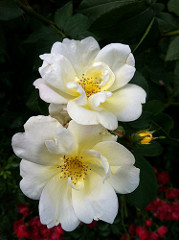

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

## 데이터셋 만들기

In [5]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


80%는 훈련에 사용, 20%는 유효성 검사에 사용

In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


80%는 훈련에 사용, 20%는 검증에 사용

In [7]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 데이터 시각화

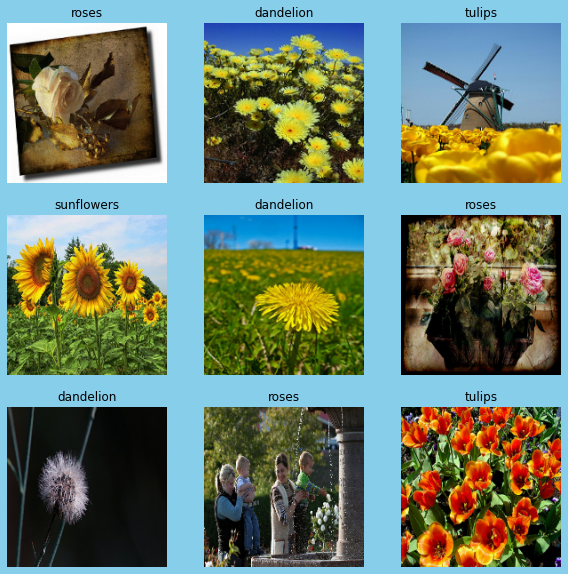

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10), facecolor='skyblue')
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


image_batch는 180x180x3 크기의 32개 이미지 묶음. 마지막 3은 컬러채널 RGB를 의미.

## 데이터 표준화 하기
RGB 값은 0~255 값으로, 신경망에 학습시키기에는 일반적으로 부적합함. 입력값을 작게 만드는 것이 보통.

In [10]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

- 생성한 레이어를 사용하려면, 
    1. map() 함수로 데이터셋에 적용시키거나 
    2. 모델 정의 단계에서 레이어를 입력층으로 추가하거나

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# 해당 픽셀의 값은 0 또는 1로 조정됨
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


- 전처리 초반에 tf.keras.preprocessing.image_dataset_from_directory의 image_size 인수로 이미지 크기를 조정했었는데,
- 위의 Rescaling 레이어를 추가한 것처럼
- layers.experimental.preprocessing.Resizing 으로 크기 조정 레이어를 추가 가능

In [12]:
# 디스크에 데이터를 캐시하는 함수
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 모델 설정 및 학습

In [13]:
num_classes = 5

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)])

In [14]:
model.compile(
    optimizer = 'adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [15]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 3)

Epoch 1/3
92/92 [==============================] - 36s 384ms/step - loss: 1.3346 - accuracy: 0.4329 - val_loss: 1.1614 - val_accuracy: 0.5259
Epoch 2/3
92/92 [==============================] - 35s 379ms/step - loss: 1.0661 - accuracy: 0.5807 - val_loss: 1.0031 - val_accuracy: 0.5981
Epoch 3/3
92/92 [==============================] - 36s 396ms/step - loss: 0.9239 - accuracy: 0.6328 - val_loss: 0.9393 - val_accuracy: 0.6172


- val_accuracy (검증 정확도) 가 accuracy보다 낮으므로 새로운 데이터에 대한 예측 정확도가 떨어진다고 볼 수 있고, 과대적합에 해당함.

In [16]:
# model.fit(
#     train_ds,
#     validation_data = val_ds,
#     epochs = 10)

- 10번 더 학습을 진행해봤으나 트레인 정확도만 올라가고, 검증 정확도는 상승이 미미하거나 오히려 떨어지는 경우도 있음. 현재 데이터셋이나 모델 설정을 바꿔야함.

## 더 나은 성능을 위한 방법들

### 미세 제어

- 자체 입력 파이프라인을 작성할 수 있음. 데이터셋의 파일 경로부터 시작하여 수행

In [17]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [18]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\user\\.keras\\datasets\\flower_photos\\tulips\\3991742794_edebc6c8a0_n.jpg'
b'C:\\Users\\user\\.keras\\datasets\\flower_photos\\daisy\\3699235066_fc09a02dfe_m.jpg'
b'C:\\Users\\user\\.keras\\datasets\\flower_photos\\roses\\5060536705_b370a5c543_n.jpg'
b'C:\\Users\\user\\.keras\\datasets\\flower_photos\\sunflowers\\4933230547_394f618009_m.jpg'
b'C:\\Users\\user\\.keras\\datasets\\flower_photos\\dandelion\\8681420404_6ae114f036_n.jpg'


- 파일의 트리 구조를 사용하여 class_names 목록을 컴파일 할 수 있음

In [19]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt']))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [20]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [21]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


- 파일 경로를 (img, label) 쌍으로 변환하는 함수 작성

In [22]:
# 경로에서 레이블 정보 추출
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [23]:
# 경로의 이미지 파일을 3차원 텐서 형식으로 변환 및 사이즈 조정
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

In [24]:
# 이미지 파일을 3차원 텐서 형식으로 취득 및 레이블 정보 추출
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [25]:
# num_parallel_calls 설정시 병렬 처리 가능
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [26]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label :", label.numpy())

Image shape:  (180, 180, 3)
Label : 2


### 성능을 올리기 위한 데이터셋 구성하기

해당 데이터세트로 모델을 훈련하려면 데이터에 대해 다음 작업이 필요함
- 스플릿이 잘 되도록 함 ( 잘 섞기 )
- 배치 처리한다.
- 가능한 빨리 배치를 사용할 수 있어야 한다.

In [27]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

## 데이터 시각화 vol.2

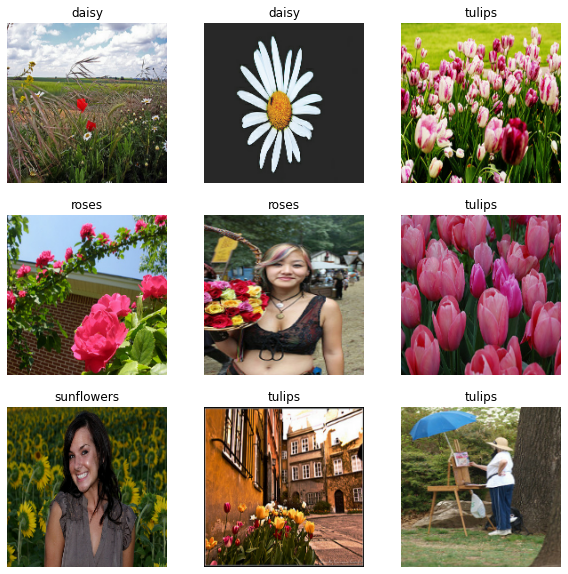

In [28]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis('off')
plt.show()

## 모델 계속 훈련하기

In [29]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 3)

Epoch 1/3
92/92 [==============================] - 39s 416ms/step - loss: 0.8155 - accuracy: 0.6856 - val_loss: 0.7527 - val_accuracy: 0.7030
Epoch 2/3
92/92 [==============================] - 37s 400ms/step - loss: 0.6149 - accuracy: 0.7708 - val_loss: 0.8222 - val_accuracy: 0.6744
Epoch 3/3
92/92 [==============================] - 38s 416ms/step - loss: 0.4295 - accuracy: 0.8379 - val_loss: 0.9740 - val_accuracy: 0.6717


## 정리
- 디스크에서 데이터 로드
- 전처리
- tf.data 를 사용하여 입력 파이프라인 작성
- 학습 및 정확도 비교, 성능을 올리기 위한 짧은 시도
- 성능을 더 올리기 위해서는? 이후 내용을 공부할 것..